In [23]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Read and cleaning data


In [24]:
#open Results_file
data = pd.read_excel ('C:/Users/a/Downloads/livraison01-20210208T081630Z-001/livraison01/Fusion.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 10 columns):
report name                         2327 non-null object
caption                             2324 non-null object
image                               2263 non-null object
Page                                2327 non-null int64
paragraphs                          2326 non-null object
Lot                                 2327 non-null int64
images_to_be_classified             2263 non-null float64
images_classified/non_structural    2263 non-null float64
images_classified/structural        2263 non-null float64
structural_check_DD                 2263 non-null float64
dtypes: float64(4), int64(2), object(4)
memory usage: 181.9+ KB


In [25]:
data[['caption', 'paragraphs']] 

,caption,paragraphs
0,Fig. 2. This cross-section AA′ (modiﬁed from B...,{'paragraph_1': 'Fig. 1. Map of the Laramide s...
1,Fig. 3. General cross-section showing the Arch...,{'paragraph_1': 'We will see later that the or...
2,Fig. 5. Proﬁle BB′. a. The geological cross-se...,{'paragraph_1': 'the Pagosa Springs and striki...
3,Fig. 6. Geological cross-sections around the E...,{'paragraph_1': 'the Pagosa Springs and striki...
4,Fig. 10. Geophysical inversion technique used ...,{'paragraph_1': 'The methodology we used to me...
...,...,...
2322,Figure 11. Experimental model showing the deve...,{'paragraph_1': 'the salt structure. The coale...
2323,through t “retaceou:,{'paragraph_1': 'The evolution of the Ek struc...
2324,Fig. 5. Profiles across the German Central Gra...,{'paragraph_1': 'Formation offshore Denmark. (...
2325,Fig. 6. Profiles from the German Central Grabe...,{'paragraph_1': 'forms the geographic link bet...


In [4]:
data.head(5)

,report name,caption,image,Page,paragraphs,Lot,images_to_be_classified,images_classified/non_structural,images_classified/structural,structural_check_DD
0,1-s2.0-S0377027315001122-main,Fig. 2. This cross-section AA′ (modiﬁed from B...,1-s2.0-S0377027315001122-main_1_structural_1.jpeg,0,{'paragraph_1': 'Fig. 1. Map of the Laramide s...,1,1.0,0.0,1.0,1.0
1,1-s2.0-S0377027315001122-main,Fig. 3. General cross-section showing the Arch...,1-s2.0-S0377027315001122-main_2_structural_2.jpeg,0,{'paragraph_1': 'We will see later that the or...,1,1.0,0.0,1.0,1.0
2,1-s2.0-S0377027315001122-main,Fig. 5. Proﬁle BB′. a. The geological cross-se...,1-s2.0-S0377027315001122-main_4_structural_3.jpeg,0,{'paragraph_1': 'the Pagosa Springs and striki...,1,1.0,0.0,1.0,1.0
3,1-s2.0-S0377027315001122-main,Fig. 6. Geological cross-sections around the E...,1-s2.0-S0377027315001122-main_5_structural_4.jpeg,0,{'paragraph_1': 'the Pagosa Springs and striki...,1,1.0,0.0,1.0,1.0
4,1-s2.0-S0377027315001122-main,Fig. 10. Geophysical inversion technique used ...,1-s2.0-S0377027315001122-main_9_structural_5.jpeg,0,{'paragraph_1': 'The methodology we used to me...,1,1.0,0.0,1.0,0.0


In [5]:
data['paragraphs'][0]

"{'paragraph_1': 'Fig. 1. Map of the Laramide structures of the region surrounding Pagosa Springs (modiﬁed from Brister and Chapin, 1994). Overlain onto the structure map are dominant fracture systems mapped by Kelly and Clinton (1960) in light grey. Proﬁle A to A′ indicates the location of the cross section shown in Fig. 2 crossing the Archuleta anticlinorium. The San Juan Mountains correspond to the area denotes as “San Juan Sag” on the map. The San Juan uplift corresponds to the potential heat source for the geothermal system feeding the Pagosa Springs. Converging arrows are used to deﬁne the synclines while the diverging arrows are used to describe the anticlines.', 'paragraph_2': 'southeast into northern New Mexico where it terminates at the Nacimiento Uplift, Chama Basin, and Brazos Uplift. These structural features resulted from the Laramide Orogeny that formed the modern day Rocky Mountains. The uplift of the Colorado Plateau initiated the Laramide Orogeny caused a total rise o

In [38]:
data['caption'][0]
df = data
df['clean_doc'] = data['caption']

In [39]:
#remove all characters 
df['clean_doc'] = data['caption'].str.replace("[^a-zA-Z#]", " ")
#remove words : (paragraph and Fig)
df['clean_doc'] = df['clean_doc'].str.replace("paragraph|Fig", "")
# make all text lowercase
df['clean_doc'] = df['clean_doc'].str.lower()


In [40]:
df['clean_doc'][0]

'     this cross section aa   modi ed from brister and chapin        cuts the archuleta anticlinorium approximately perpendicular to its folding axis shown in      at about the center of the cross section is the precambrian basement fault believed to in uence the location of the anticlinorium  some of the main tectonic faults discussed in this work are parallel to the archuleta anticlinorium  the san juan mountains correspond to the area denotes as  san juan sag  on the map '

In [41]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
import nltk
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')



# tokenization
tokenized_doc = df['clean_doc'].str.split()





[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [44]:
df['clean_doc'] = df['clean_doc'].astype(str)
df['clean_doc'] = df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df['clean_doc'] 

0       this cross section modi from brister chapin cu...
1       general cross section showing archuleta anticl...
2       geological cross section adapted from galloway...
3       geological cross sections around eight mike me...
4       geophysical inversion technique used present s...
                              ...                        
2322    experimental model showing development symmetr...
2323                                     through retaceou
2324    profiles across german central graben mainly a...
2325    profiles from german central graben into danis...
2326    sketch hydrocarbon generation migration accumu...
Name: clean_doc, Length: 2327, dtype: object

# Dictionnaire et corpus


In [45]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['clean_doc'] = detokenized_doc

In [46]:
detokenized_doc

['cross section modi brister chapin cuts archuleta anticlinorium approximately perpendicular folding axis shown center cross section precambrian basement fault believed uence location anticlinorium main tectonic faults discussed work parallel archuleta anticlinorium juan mountains correspond area denotes juan',
 'general cross section showing archuleta anticlinorium juan volcanic mountains luis basin laying easter side section',
 'geological cross section adapted galloway formations general uniform thickness unless eroded surface locations northeast anticlinal axis modi cross section faults cross section mapped faults pagosa springs area added vertical conduit springs line beneath springs indicating springs root located dakota formation picture shows springs mound around pool travertine covering area picture credit sullivan springs pagosa springs colorado named modi',
 'geological cross sections around eight mike mesa victoire faults position determined using geological information inc

In [47]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

docs_words = list(sent_to_words(df['clean_doc']))

print(docs_words[:1])

[['cross', 'section', 'modi', 'brister', 'chapin', 'cuts', 'archuleta', 'anticlinorium', 'approximately', 'perpendicular', 'folding', 'axis', 'shown', 'center', 'cross', 'section', 'precambrian', 'basement', 'fault', 'believed', 'uence', 'location', 'anticlinorium', 'main', 'tectonic', 'faults', 'discussed', 'work', 'parallel', 'archuleta', 'anticlinorium', 'juan', 'mountains', 'correspond', 'area', 'denotes', 'juan']]


In [35]:
# Build the bigram models
bigram = gensim.models.Phrases(print(docs_words[:1])
, min_count=5, threshold=100) # higher threshold fewer phrases.


# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# See bigram example
print(bigram_mod[docs_words[0]])

[['cross', 'section', 'modi', 'brister', 'chapin', 'cuts', 'archuleta', 'anticlinorium', 'approximately', 'perpendicular', 'folding', 'axis', 'shown', 'center', 'cross', 'section', 'precambrian', 'basement', 'fault', 'believed', 'uence', 'location', 'anticlinorium', 'main', 'tectonic', 'faults', 'discussed', 'work', 'parallel', 'archuleta', 'anticlinorium', 'juan', 'mountains', 'correspond', 'area', 'denotes', 'juan']]
['cross', 'section', 'modi', 'brister', 'chapin', 'cuts', 'archuleta', 'anticlinorium', 'approximately', 'perpendicular', 'folding', 'axis', 'shown', 'center', 'cross', 'section', 'precambrian', 'basement', 'fault', 'believed', 'uence', 'location', 'anticlinorium', 'main', 'tectonic', 'faults', 'discussed', 'work', 'parallel', 'archuleta', 'anticlinorium', 'juan', 'mountains', 'correspond', 'area', 'denotes', 'juan']


In [36]:
# Define functions for stopwords, bigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]



def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [37]:
# Remove Stop Words
docs_words_nostops = remove_stopwords(docs_words)

# Form Bigrams
docs_words_bigrams = make_bigrams(docs_words_nostops)
docs_words_bigrams


[['cross',
  'section',
  'modi',
  'brister',
  'chapin',
  'cuts',
  'archuleta',
  'anticlinorium',
  'approximately',
  'perpendicular',
  'folding',
  'axis',
  'shown',
  'center',
  'cross',
  'section',
  'precambrian',
  'basement',
  'fault',
  'believed',
  'uence',
  'location',
  'anticlinorium',
  'main',
  'tectonic',
  'faults',
  'discussed',
  'work',
  'parallel',
  'archuleta',
  'anticlinorium',
  'juan',
  'mountains',
  'correspond',
  'area',
  'denotes',
  'juan'],
 ['general',
  'cross',
  'section',
  'showing',
  'archuleta',
  'anticlinorium',
  'juan',
  'volcanic',
  'mountains',
  'luis',
  'basin',
  'laying',
  'easter',
  'side',
  'section'],
 ['geological',
  'cross',
  'section',
  'adapted',
  'galloway',
  'formations',
  'general',
  'uniform',
  'thickness',
  'unless',
  'eroded',
  'surface',
  'locations',
  'northeast',
  'anticlinal',
  'axis',
  'modi',
  'cross',
  'section',
  'faults',
  'cross',
  'section',
  'mapped',
  'faults',
  

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(docs_words_bigrams)

# Create Corpus
texts = docs_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1)]]


In [19]:
id2word[0]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('anticlinorium', 3),
  ('approximately', 1),
  ('archuleta', 2),
  ('area', 1),
  ('axis', 1),
  ('basement', 1),
  ('believed', 1),
  ('brister', 1),
  ('center', 1),
  ('chapin', 1),
  ('correspond', 1),
  ('cross', 2),
  ('cuts', 1),
  ('denotes', 1),
  ('discussed', 1),
  ('fault', 1),
  ('faults', 1),
  ('folding', 1),
  ('juan', 2),
  ('location', 1),
  ('main', 1),
  ('modi', 1),
  ('mountains', 1),
  ('parallel', 1),
  ('perpendicular', 1),
  ('precambrian', 1),
  ('section', 2),
  ('shown', 1),
  ('tectonic', 1),
  ('uence', 1),
  ('work', 1)]]

In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"grabens" + 0.031*"crustal" + 0.030*"facies" + 0.021*"flow" + '
  '0.020*"transect" + 0.019*"shelf" + 0.019*"pyrenean" + 0.015*"hanging" + '
  '0.014*"northwest" + 0.013*"heat"'),
 (1,
  '0.048*"salt" + 0.021*"extension" + 0.019*"basin" + 0.017*"margin" + '
  '0.016*"evolution" + 0.014*"sediments" + 0.014*"tectonic" + '
  '0.011*"deformation" + 0.010*"early" + 0.010*"structures"'),
 (2,
  '0.041*"fault" + 0.033*"graben" + 0.027*"seismic" + 0.026*"faults" + '
  '0.021*"profile" + 0.016*"interpreted" + 0.013*"north" + 0.013*"normal" + '
  '0.013*"high" + 0.012*"strata"'),
 (3,
  '0.035*"model" + 0.020*"lines" + 0.020*"crust" + 0.018*"time" + '
  '0.016*"black" + 0.012*"order" + 0.011*"indicate" + 0.011*"dashed" + '
  '0.010*"level" + 0.010*"different"'),
 (4,
  '0.033*"jurassic" + 0.024*"rift" + 0.024*"upper" + 0.019*"basement" + '
  '0.017*"formation" + 0.016*"present" + 0.014*"unit" + 0.013*"detachment" + '
  '0.013*"stage" + 0.011*"lower"'),
 (5,
  '0.062*"cretaceous" + 

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=docs_words_bigrams, start=2, limit=40, step=6)

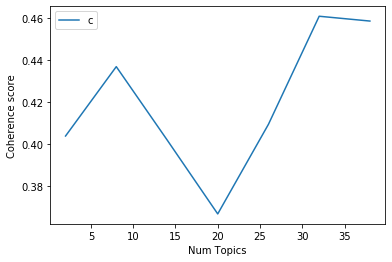

In [24]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig("C:/Users/a/Downloads/livraison01-20210208T081630Z-001/livraison01/plot_modele")
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv,2 ))

Num Topics = 2  has Coherence Value of 0.4
Num Topics = 8  has Coherence Value of 0.44
Num Topics = 14  has Coherence Value of 0.4
Num Topics = 20  has Coherence Value of 0.37
Num Topics = 26  has Coherence Value of 0.41
Num Topics = 32  has Coherence Value of 0.46
Num Topics = 38  has Coherence Value of 0.46


In [26]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.035*"grabens" + 0.031*"crustal" + 0.030*"facies" + 0.021*"flow" + '
  '0.020*"transect" + 0.019*"shelf" + 0.019*"pyrenean" + 0.015*"hanging" + '
  '0.014*"northwest" + 0.013*"heat"'),
 (1,
  '0.048*"salt" + 0.021*"extension" + 0.019*"basin" + 0.017*"margin" + '
  '0.016*"evolution" + 0.014*"sediments" + 0.014*"tectonic" + '
  '0.011*"deformation" + 0.010*"early" + 0.010*"structures"'),
 (2,
  '0.041*"fault" + 0.033*"graben" + 0.027*"seismic" + 0.026*"faults" + '
  '0.021*"profile" + 0.016*"interpreted" + 0.013*"north" + 0.013*"normal" + '
  '0.013*"high" + 0.012*"strata"'),
 (3,
  '0.035*"model" + 0.020*"lines" + 0.020*"crust" + 0.018*"time" + '
  '0.016*"black" + 0.012*"order" + 0.011*"indicate" + 0.011*"dashed" + '
  '0.010*"level" + 0.010*"different"'),
 (4,
  '0.033*"jurassic" + 0.024*"rift" + 0.024*"upper" + 0.019*"basement" + '
  '0.017*"formation" + 0.016*"present" + 0.014*"unit" + 0.013*"detachment" + '
  '0.013*"stage" + 0.011*"lower"'),
 (5,
  '0.062*"cretaceous" + 

In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.345690251941647

Coherence Score:  0.4368505634928809


In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [29]:
# Convert to list
data1 = data.caption.values.tolist()
pprint(data1[:1])

['Fig. 2. This cross-section AA′ (modiﬁed from Brister and Chapin, 1994) cuts '
 'the Archuleta anticlinorium approximately perpendicular to its folding axis '
 'shown in Fig. 1. At about the center of the cross section is the Precambrian '
 'basement fault believed to inﬂuence the location of the anticlinorium. Some '
 'of the main tectonic faults discussed in this work are parallel to the '
 'Archuleta anticlinorium. The San Juan Mountains correspond to the area '
 'denotes as “San Juan Sag” on the map.']


### Liste la thématique majoritaire pour chaque document, accompagnée par ses mots les plus probables

In [30]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    i=0
    for i, row in enumerate(ldamodel[corpus]):
        #print(row[0])            
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        #print(row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data1)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show

df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5279,"fault, graben, seismic, faults, profile, inter...",Fig. 2. This cross-section AA′ (modiﬁed from B...
1,1,2.0,0.3780,"fault, graben, seismic, faults, profile, inter...",Fig. 3. General cross-section showing the Arch...
2,2,7.0,0.6671,"section, cross, basin, seismic, location, show...",Fig. 5. Proﬁle BB′. a. The geological cross-se...
3,3,7.0,0.3767,"section, cross, basin, seismic, location, show...",Fig. 6. Geological cross-sections around the E...
4,4,0.0,0.3800,"grabens, crustal, facies, flow, transect, shel...",Fig. 10. Geophysical inversion technique used ...
...,...,...,...,...,...
2322,2322,1.0,0.4334,"salt, extension, basin, margin, evolution, sed...",Figure 11. Experimental model showing the deve...
2323,2323,7.0,0.2510,"section, cross, basin, seismic, location, show...",through t “retaceou:
2324,2324,2.0,0.6441,"fault, graben, seismic, faults, profile, inter...",Fig. 5. Profiles across the German Central Gra...
2325,2325,2.0,0.7568,"fault, graben, seismic, faults, profile, inter...",Fig. 6. Profiles from the German Central Grabe...


### Les documents les plus "représentatifs" de chaque thématique

In [31]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4611,"grabens, crustal, facies, flow, transect, shel...",Ps. 10. (VA) Ed Stel) SIG OF WH KOUIOUNSOU OUL...
1,1.0,0.7512,"salt, extension, basin, margin, evolution, sed...",FIGURE 4 | Sketch illustrating trigger mechani...
2,2.0,0.7568,"fault, graben, seismic, faults, profile, inter...",Fig. 6. Profiles from the German Central Grabe...
3,3.0,0.8732,"model, lines, crust, time, black, order, indic...",Fig. 12. (A) Ternary diagram or 3-part simplex...
4,4.0,0.6547,"jurassic, rift, upper, basement, formation, pr...",Figure 15. First restoration steps showing the...
5,5.0,0.4852,"cretaceous, middle, late, miocene, figure, leg...",Fig. 1. Map of the Qikou Depression in North C...
6,6.0,0.9150,"growth, simplified, yellow, channel, dimension...",‘paydefoid aq Aew (gg “Siq) puels] AOWJeq (q p...
7,7.0,0.7937,"section, cross, basin, seismic, location, show...",Fig. 4. (a) Geological map of the Val Roveto a...


### Répartition des sujets dans les documents

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
df_dominant_topics["id"] = data["image"]
# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,id
0.0,2.0,"fault, graben, seismic, faults, profile, inter...",42.0,0.0180,1-s2.0-S0377027315001122-main_1_structural_1.jpeg
1.0,2.0,"fault, graben, seismic, faults, profile, inter...",310.0,0.1332,1-s2.0-S0377027315001122-main_2_structural_2.jpeg
2.0,7.0,"section, cross, basin, seismic, location, show...",499.0,0.2144,1-s2.0-S0377027315001122-main_4_structural_3.jpeg
3.0,7.0,"section, cross, basin, seismic, location, show...",270.0,0.1160,1-s2.0-S0377027315001122-main_5_structural_4.jpeg
4.0,0.0,"grabens, crustal, facies, flow, transect, shel...",252.0,0.1083,1-s2.0-S0377027315001122-main_9_structural_5.jpeg
...,...,...,...,...,...
2322.0,1.0,"salt, extension, basin, margin, evolution, sed...",NaN,NaN,BLTN06112_10_structural_4.jpeg
2323.0,7.0,"section, cross, basin, seismic, location, show...",NaN,NaN,BLTN06112_11_structural_5.jpeg
2324.0,2.0,"fault, graben, seismic, faults, profile, inter...",NaN,NaN,1-s2.0-S0264817219305690-main_0_structural_1.jpeg
2325.0,2.0,"fault, graben, seismic, faults, profile, inter...",NaN,NaN,1-s2.0-S0264817219305690-main_1_structural_2.jpeg


In [33]:
def separate_words(df):
    # Ajouter une colonne avec les différentes technologies et en duppliquant les lignes des autres colonnes
    long_df  = df.assign(keywordd = df.Topic_Keywords.str.split(", ")).explode('keywordd') 
    # A partir du long dataset créer large qui contient une colonne pour chaque technologie 
    long_df['values'] = 1
    large_df = pd.pivot_table(long_df, index = long_df.index, columns = ['keywordd'], values = 'values', fill_value = 0).reset_index()
    # Fusionner avec le dataset orginal
    transformed_df = df.merge(large_df, on = large_df.index, how ='left')
    # Supprimer les colonnes non utilié colonnes
    transformed_df = transformed_df.drop(['Topic_Keywords', "Dominant_Topic", "Perc_Documents"], axis = 1)
    return transformed_df

In [34]:
lab_df = separate_words(df_dominant_topics)

In [35]:
lab_df.to_csv(r'C:/Users/a/Downloads/livraison01-20210208T081630Z-001/livraison01/Label.csv', index = False)
print(lab_df)

      key_0  Num_Documents                                                 id  \
0         0           42.0  1-s2.0-S0377027315001122-main_1_structural_1.jpeg   
1         1          310.0  1-s2.0-S0377027315001122-main_2_structural_2.jpeg   
2         2          499.0  1-s2.0-S0377027315001122-main_4_structural_3.jpeg   
3         3          270.0  1-s2.0-S0377027315001122-main_5_structural_4.jpeg   
4         4          252.0  1-s2.0-S0377027315001122-main_9_structural_5.jpeg   
...     ...            ...                                                ...   
2322   2322            NaN                     BLTN06112_10_structural_4.jpeg   
2323   2323            NaN                     BLTN06112_11_structural_5.jpeg   
2324   2324            NaN  1-s2.0-S0264817219305690-main_0_structural_1.jpeg   
2325   2325            NaN  1-s2.0-S0264817219305690-main_1_structural_2.jpeg   
2326   2326            NaN  1-s2.0-S0264817219305690-main_5_structural_3.jpeg   

       index  albian  area 

In [36]:
#import os 
#import glob
#import shutil
#dossier = "c:/Users/a/Downloads/Images-/**"
#parent_direct = "c:/Users/a/Downloads/Images-/Images/"
#destin_img = "c:/Users/a/Downloads/Images-/Images"
#files_1 = glob.glob(dossier, recursive =True)
#for i in files_1 :
#    if i.endswith(('.jpg', '.png', '.jpeg')) :
#        path_i = os.path.join(parent_direct, "images") 
#        os.makedirs(path_i, exist_ok=True)
#        shutil.move(i, destin_img)

# Multilabel classification


In [109]:
image_directory = 'c:/Users/a/Downloads/Images-/Images/'
df = pd.read_csv('C:/Users/a/Downloads/livraison01-20210208T081630Z-001/livraison01/Labels.csv')    
print(df.head())     # printing first five rows of the file
print(df.columns)

   key_0  Num_Documents                                                 id  \
0      0           42.0  1-s2.0-S0377027315001122-main_1_structural_1.jpeg   
1      1          310.0  1-s2.0-S0377027315001122-main_2_structural_2.jpeg   
2      2          499.0  1-s2.0-S0377027315001122-main_4_structural_3.jpeg   
3      3          270.0  1-s2.0-S0377027315001122-main_5_structural_4.jpeg   
4      4          252.0  1-s2.0-S0377027315001122-main_9_structural_5.jpeg   

   index  albian  area  basement  basin  black  channel  ...  subsidence  \
0    0.0       0     0         0      0      0        0  ...           0   
1    1.0       0     0         0      0      0        0  ...           0   
2    2.0       0     1         0      1      0        0  ...           0   
3    3.0       0     1         0      1      0        0  ...           0   
4    4.0       0     0         0      0      0        0  ...           0   

   subsurface  tectonic  time  transect  triangles  unit  upper  version  

In [110]:
df = df.iloc[:2200]
SIZE = 200
X_dataset = []  
for i in tqdm(range(df.shape[0])):
    img = image.load_img(image_directory + df['id'][i], target_size=(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
    
X = np.array(X_dataset)

100%|██████████████████████████████████████████████████████████████████████████████| 2200/2200 [01:35<00:00, 23.14it/s]


In [112]:
y = np.array(df.drop(['key_0', 'Num_Documents', 'id', 'index' ], axis=1))

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [115]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE,SIZE,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(78, activation='sigmoid'))


In [116]:
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 196, 196, 16)      1216      
_________________________________________________________________
batch_normalization_5 (Batch (None, 196, 196, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 98, 98, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 94, 94, 32)        12832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 47, 47, 32)       

In [117]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)


Train on 1540 samples, validate on 660 samples
Epoch 1/10
1540/1540 [==============================] - 163s 106ms/step - loss: 0.6818 - accuracy: 0.6717 - val_loss: 0.4571 - val_accuracy: 0.8724
Epoch 2/10
1540/1540 [==============================] - 158s 102ms/step - loss: 0.4628 - accuracy: 0.8151 - val_loss: 0.3683 - val_accuracy: 0.8657
Epoch 3/10
1540/1540 [==============================] - 151s 98ms/step - loss: 0.4129 - accuracy: 0.8409 - val_loss: 0.3582 - val_accuracy: 0.8742
Epoch 4/10
1540/1540 [==============================] - 156s 101ms/step - loss: 0.3912 - accuracy: 0.8502 - val_loss: 0.3267 - val_accuracy: 0.8739
Epoch 5/10
1540/1540 [==============================] - 155s 101ms/step - loss: 0.3821 - accuracy: 0.8529 - val_loss: 0.3399 - val_accuracy: 0.8674
Epoch 6/10
1540/1540 [==============================] - 170s 110ms/step - loss: 0.3784 - accuracy: 0.8542 - val_loss: 0.3394 - val_accuracy: 0.8720
Epoch 7/10
1540/1540 [==============================] - 155s 101ms

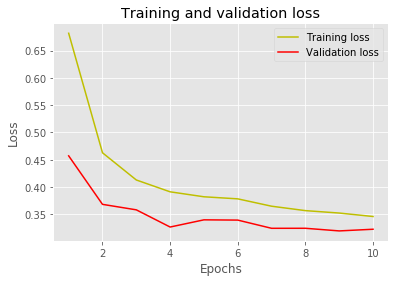

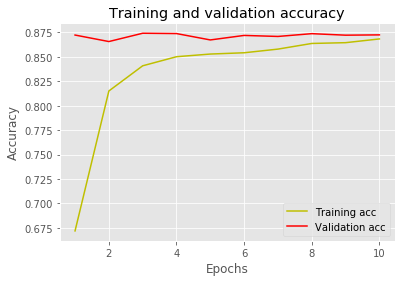

In [118]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.style.use("ggplot")
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("C:/Users/a/Downloads/livraison01-20210208T081630Z-001/livraison01/plot_loss_sig")
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig("C:/Users/a/Downloads/livraison01-20210208T081630Z-001/livraison01/plot_acc_sig")
plt.show()



#### Essaie avec Softmax 

In [111]:
#model = Sequential()

#model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE,SIZE,3)))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

#model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(78, activation='softmax'))

In [119]:
#model.summary()
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)



#### Exemple sur une image

sections (0.831)
area (0.622)
line (0.595)
channel (0.523)
rift (0.512)
seismic (0.508)
index (0.497)
shelf (0.482)
salt (0.462)
legend (0.381)


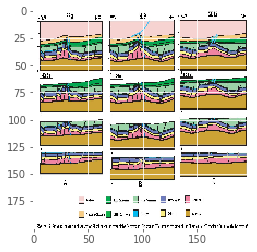

In [120]:
img = image.load_img('c:/Users/a/Downloads/Images-/Images/BLTN06112_11_structural_5.jpeg', target_size=(SIZE,SIZE,3))
img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)
classes = np.array(df.columns[2:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

#Print classes and corresponding probabilities
for i in range(10):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))



### Affichage de la photo avec les labels 

In [121]:
import cv2
import imutils
# construct the argument parse and parse the arguments
path_image =  "c:/Users/a/Downloads/Images-/Images/BLTN06112_11_structural_5.jpeg"
# load the image
image = cv2.imread(path_image)
output = imutils.resize(image, width=400)
 
# pre-process the image for classification# loop over the indexes of the high confidence class labels
for (i, j) in enumerate(sorted_categories):
# build the label and draw the label on the image
    label = "{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]])
    cv2.putText(output, label, (10, (i * 30) + 25), 
    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2) 


# show the output image
cv2.imshow("Output", output)
cv2.waitKey(1)


-1